In [46]:
# Imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img,save_img
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import shutil
import keras
from keras import backend as K

import tensorflow
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications.vgg16 import VGG16, preprocess_input


Load Data 

In [4]:
current_path = os.getcwd()
training_directory_path = '/ISIC2019Dataset/ISIC_2019_Training_Input/'
training_metadata_path = '/ISIC2019Dataset/ISIC_2019_Training_Metadata.csv'
ground_truth_path = '/ISIC2019Dataset/ISIC_2019_Training_GroundTruth.csv'
test_directory_path = '/ISIC2019Dataset/ISIC_2019_Test_Input/'
test_metadata_path = '/ISIC2019Dataset/ISIC_2019_Test_Metadata.csv'

training_metadata_table = pd.read_csv(current_path + training_metadata_path)
test_metadata_table = pd.read_csv(current_path + test_metadata_path)
ground_truth_table = pd.read_csv(current_path + ground_truth_path)

**LABELS**
- **MEL** - Melanoma
- **NV** - Melanocytic nevus
- **BCC** - Basal cell carcinoma
- **AK** - Actinic keratosis
- **BKL** - Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
- **DF** - Dermatofibroma
- **VASC** - Vascular lesion
- **SCC** - Squamous cell carcinoma
- **UNK** - None of the above


In [5]:
# ground_truth_table.drop('UNK',axis=1,inplace=True)
print(ground_truth_table.head())

          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0


In [6]:
print(training_metadata_table.head())

          image  age_approx anatom_site_general lesion_id     sex
0  ISIC_0000000        55.0      anterior torso       NaN  female
1  ISIC_0000001        30.0      anterior torso       NaN  female
2  ISIC_0000002        60.0     upper extremity       NaN  female
3  ISIC_0000003        30.0     upper extremity       NaN    male
4  ISIC_0000004        80.0     posterior torso       NaN    male


In [7]:
print(training_metadata_table.shape)
print(ground_truth_table.shape)

(25331, 5)
(25331, 10)


In [8]:
training_metadata_table.isnull().sum()

image                     0
age_approx              437
anatom_site_general    2631
lesion_id              2084
sex                     384
dtype: int64

In [9]:
training_metadata_table['age_approx'].fillna((training_metadata_table['age_approx'].mean()), inplace=True)
training_metadata_table.dropna(subset=['anatom_site_general', 'lesion_id', 'sex'], inplace=True)
training_metadata_table.isnull().sum()

image                  0
age_approx             0
anatom_site_general    0
lesion_id              0
sex                    0
dtype: int64

Text(0.5, 1.0, 'Gender of Patient')

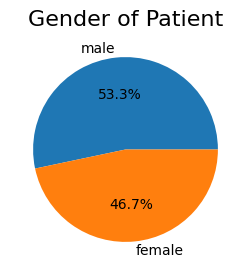

In [10]:
bar, ax = plt.subplots(figsize = (3,3))
plt.pie(training_metadata_table['sex'].value_counts(), labels = training_metadata_table['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

Text(0.5, 1.0, 'Histogram of Age of Patients')

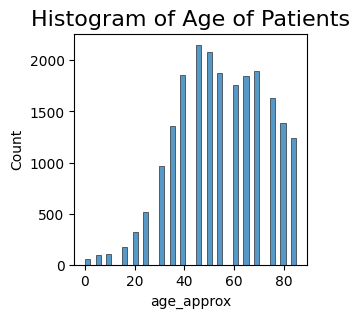

In [11]:
bar, ax = plt.subplots(figsize=(3, 3))
sns.histplot(training_metadata_table['age_approx'])
plt.title('Histogram of Age of Patients', size=16)

In [12]:
ground_truth_table.replace(['NaN', 'N/A', 'NA', 'n/a', 'n.a.', 'N#A', 'n#a', '?'], 'other', inplace=True)
missing_df =  ground_truth_table.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_df["% of Missing Values"] = round((missing_df["Total No. of Missing Values"]/len( ground_truth_table))*100,2)
missing_df

,Total No. of Missing Values,% of Missing Values
image,0,0.0
MEL,0,0.0
NV,0,0.0
BCC,0,0.0
AK,0,0.0
BKL,0,0.0
DF,0,0.0
VASC,0,0.0
SCC,0,0.0
UNK,0,0.0


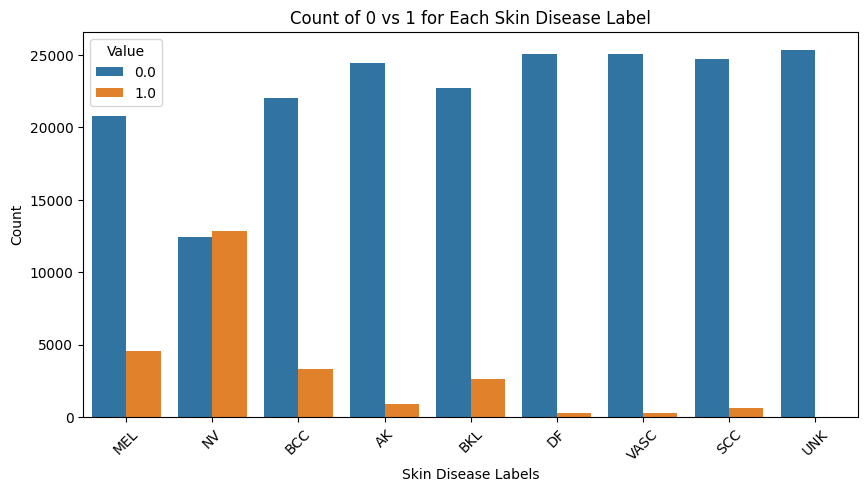

In [13]:
melted_df = pd.melt(ground_truth_table, id_vars=['image'], var_name='Label', value_name='Value')

plt.figure(figsize=(10, 5)) 
sns.countplot(x='Label', hue='Value', data=melted_df)
plt.title('Count of 0 vs 1 for Each Skin Disease Label')
plt.xlabel('Skin Disease Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()

In [14]:
classes=['NV','BCC','AK','BKL','DF','VASC','SCC','MEL']

ground_truth_table['label'] = ground_truth_table[classes].idxmax(axis=1)
ground_truth_table.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,label
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


In [15]:
classes=['NV','BCC','AK','BKL','DF','VASC','SCC','MEL']

lesion_type_mapping = {lesion: idx+1 for idx, lesion in enumerate(classes)}

ground_truth_table['label'] = ground_truth_table[classes].idxmax(axis=1)

merged_data = pd.merge(training_metadata_table, ground_truth_table[['image', 'label']], on='image', how='left')

merged_data['lesion_type'] = merged_data['label']
merged_data['lesion_type_id'] = merged_data['lesion_type'].map(lesion_type_mapping)

merged_data = merged_data.drop(columns=['label'])

merged_data.head()

,image,age_approx,anatom_site_general,lesion_id,sex,lesion_type,lesion_type_id
0,ISIC_0012653_downsampled,50.0,posterior torso,MSK4_0011169,female,NV,1
1,ISIC_0012654_downsampled,30.0,lower extremity,MSK4_0011170,female,NV,1
2,ISIC_0012655_downsampled,35.0,upper extremity,MSK4_0011171,female,NV,1
3,ISIC_0012656_downsampled,45.0,posterior torso,MSK4_0011172,male,NV,1
4,ISIC_0012657_downsampled,20.0,upper extremity,MSK4_0011173,female,NV,1


Total images of NV : 12875
Total images of BCC : 3323
Total images of AK : 867
Total images of BKL : 2624
Total images of DF : 239
Total images of VASC : 253
Total images of SCC : 628
Total images of MEL : 4522


/tmp/ipykernel_3101551/2760195501.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="viridis")


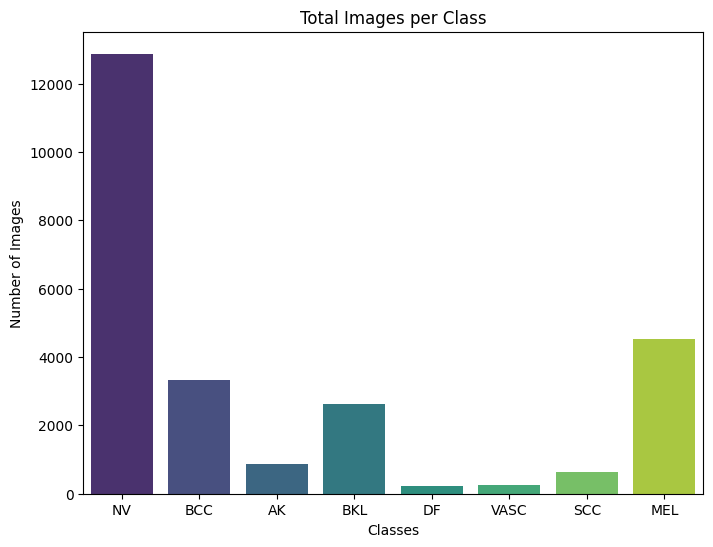

In [16]:
image_counts = {class_name: len(ground_truth_table[ground_truth_table[class_name] > 0]) for class_name in classes}

# Print the total images for each class
for class_name in classes:
    print(f"Total images of {class_name} : {image_counts[class_name]}")

plt.figure(figsize=(8, 6))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="viridis")
plt.title('Total Images per Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

In [17]:
lesion_image_count = merged_data.groupby('lesion_id').count()

lesion_single_image = lesion_image_count[lesion_image_count['image'] == 1]

lesion_single_image.reset_index(inplace=True)

lesion_single_image.head()

,lesion_id,image,age_approx,anatom_site_general,sex,lesion_type,lesion_type_id
0,BCN_0000013,1,1,1,1,1,1
1,BCN_0000020,1,1,1,1,1,1
2,BCN_0000039,1,1,1,1,1,1
3,BCN_0000053,1,1,1,1,1,1
4,BCN_0000059,1,1,1,1,1,1


In [18]:
# Identify lesion_ids that have only one image
unique_list = list(lesion_single_image['lesion_id'])

def find_duplicates(x):
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

merged_data['duplicates'] = merged_data['lesion_id']

merged_data['duplicates'] = merged_data['duplicates'].apply(find_duplicates)

merged_data.tail()


,image,age_approx,anatom_site_general,lesion_id,sex,lesion_type,lesion_type_id,duplicates
21311,ISIC_0073247,85.0,head/neck,BCN_0003925,female,BCC,2,has_duplicates
21312,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,BKL,4,has_duplicates
21313,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,MEL,8,has_duplicates
21314,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,NV,1,has_duplicates
21315,ISIC_0073254,50.0,upper extremity,BCN_0001079,male,BKL,4,has_duplicates


In [19]:
merged_data['duplicates'].value_counts()

duplicates
has_duplicates    15959
no_duplicates      5357
Name: count, dtype: int64

In [20]:
no_duplicate_data = merged_data[merged_data['duplicates'] == 'no_duplicates']
no_duplicate_data.shape

(5357, 8)

In [27]:
y = no_duplicate_data['lesion_type']

_, val_data = train_test_split(no_duplicate_data, test_size=0.17, random_state=101, stratify=y)

print(val_data.shape)

print(val_data['lesion_type'].value_counts())

(911, 8)
lesion_type
NV      623
BKL     107
MEL      74
BCC      60
SCC      18
AK       14
VASC      8
DF        7
Name: count, dtype: int64


In [28]:
# split into train or validation
def find_val_rows(x):
    val_list = list(val_data['image'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'


merged_data['train_or_val'] = merged_data['image']
merged_data['train_or_val'] = merged_data['train_or_val'].apply(find_val_rows)
   
train_data = merged_data[merged_data['train_or_val'] == 'train']


print(len(train_data))
print(len(val_data))

20405
911


In [29]:
print(train_data['lesion_type'].value_counts())
print(val_data['lesion_type'].value_counts())

lesion_type
NV      9128
MEL     4027
BCC     3185
BKL     2188
AK       831
SCC      604
DF       228
VASC     214
Name: count, dtype: int64
lesion_type
NV      623
BKL     107
MEL      74
BCC      60
SCC      18
AK       14
VASC      8
DF        7
Name: count, dtype: int64


In [31]:
# base_dir = current_path + '/ISIC2019Dataset/ISIC_2019_Images/'
# train_dir = os.path.join(base_dir, 'train_dir')
# val_dir = os.path.join(base_dir, 'val_dir')

# if not os.path.exists(train_dir):
#     os.mkdir(train_dir)

# if not os.path.exists(val_dir):
#     os.mkdir(val_dir)

# for c in classes:
#     # folders inside train_dir
#     class_train_dir = os.path.join(train_dir, c)
#     if not os.path.exists(class_train_dir):
#         os.mkdir(class_train_dir)

#     # folders inside val_dir
#     class_val_dir = os.path.join(val_dir, c)
#     if not os.path.exists(class_val_dir):
#         os.mkdir(class_val_dir)

# print("Folders created successfully!")

Folders created successfully!


In [33]:
train_data

,image,age_approx,anatom_site_general,lesion_id,sex,lesion_type,lesion_type_id,duplicates,train_or_val
0,ISIC_0012653_downsampled,50.0,posterior torso,MSK4_0011169,female,NV,1,no_duplicates,train
1,ISIC_0012654_downsampled,30.0,lower extremity,MSK4_0011170,female,NV,1,no_duplicates,train
2,ISIC_0012655_downsampled,35.0,upper extremity,MSK4_0011171,female,NV,1,no_duplicates,train
4,ISIC_0012657_downsampled,20.0,upper extremity,MSK4_0011173,female,NV,1,no_duplicates,train
5,ISIC_0012658_downsampled,40.0,posterior torso,MSK4_0010465,male,NV,1,no_duplicates,train
...,...,...,...,...,...,...,...,...,...
21311,ISIC_0073247,85.0,head/neck,BCN_0003925,female,BCC,2,has_duplicates,train
21312,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,BKL,4,has_duplicates,train
21313,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,MEL,8,has_duplicates,train
21314,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,NV,1,has_duplicates,train


In [40]:
# merged_data.set_index('image', inplace=True)
folder = os.listdir(current_path + training_directory_path)

train_list = list(train_data['image'])
val_list = list(val_data['image'])



for image in train_list:
    
    fname = image + '.jpg'
    label = merged_data.loc[image,'lesion_type']
    
    if fname in folder:
        src = os.path.join(current_path + training_directory_path, fname)
        dst = os.path.join(train_dir, label, fname)
        print(src)
        print(dst)
        shutil.copyfile(src, dst)



for image in val_list:
    
    fname = image + '.jpg'
    label = merged_data.loc[image,'lesion_type']
    
    if fname in folder:
        src = os.path.join(current_path + training_directory_path, fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)


VGG16 Model

In [41]:
print("Train directory:")
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(train_dir, cls)))} images")

print("\nValidation directory:")
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(val_dir, cls)))} images")

Train directory:
NV: 9128 images
BCC: 3185 images
AK: 831 images
BKL: 2188 images
DF: 228 images
VASC: 214 images
SCC: 604 images
MEL: 4027 images

Validation directory:
NV: 623 images
BCC: 60 images
AK: 14 images
BKL: 107 images
DF: 7 images
VASC: 8 images
SCC: 18 images
MEL: 74 images


In [45]:
num_aug_images_wanted = 9200  
batch_size = 50

# Loop through each class to perform augmentation
for img_class in classes:
    
    # Create a temporary directory for augmentation
    aug_dir = os.path.join(base_dir, 'aug_dir')  # Augmentation directory

    # Remove the directory if it exists to avoid the error
    if os.path.exists(aug_dir):
        shutil.rmtree(aug_dir)
    
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, 'img_dir')  # Directory for class images
    os.mkdir(img_dir)

    # List all images in the specific class folder (train_dir)
    img_list = os.listdir(os.path.join(train_dir, img_class))

    # Copy images from the class's train directory to the temporary img_dir
    for fname in img_list:
        src = os.path.join(train_dir, img_class, fname)
        dst = os.path.join(img_dir, fname)
        shutil.copyfile(src, dst)

    # Define the path to the directory containing images for augmentation
    path = aug_dir
    save_path = os.path.join(train_dir, img_class)  # Save the augmented images to the same class folder

    # Create a data generator with augmentation
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    # Create the data generator
    aug_datagen = datagen.flow_from_directory(
        path,
        save_to_dir=save_path,
        save_format='jpg',
        target_size=(224, 224),
        batch_size=batch_size
    )

    # Calculate the number of batches needed to generate enough augmented images
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))

    # Generate augmented images until the desired number is reached
    for i in range(num_batches):
        imgs, labels = next(aug_datagen)

    # Clean up: remove the temporary augmentation directory
    shutil.rmtree(aug_dir)

print("Augmentation complete for all classes!")

Found 9128 images belonging to 1 classes.
Found 3185 images belonging to 1 classes.
Found 831 images belonging to 1 classes.
Found 2188 images belonging to 1 classes.
Found 228 images belonging to 1 classes.
Found 214 images belonging to 1 classes.
Found 604 images belonging to 1 classes.
Found 4027 images belonging to 1 classes.
Augmentation complete for all classes!


In [48]:
num_train_samples = len(train_data)  
num_val_samples = len(val_data)      

train_batch_size = 20
val_batch_size = 20

# VGG16 requires 224x224 image size
image_size = 224

# steps per epoch
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

# data augmentation and preprocessing
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # VGG16's preprocessing function
)

# load training and validation batches
train_batches = datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=train_batch_size
)

valid_batches = datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=val_batch_size
)

test_batches = datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=1,
    shuffle=False
)

vgg16_model = VGG16()

vgg16_model.summary()

Found 70874 images belonging to 8 classes.
Found 911 images belonging to 8 classes.
Found 911 images belonging to 8 classes.


2024-10-11 16:12:39.934026: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-10-11 16:12:40.127690: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-10-11 16:12:40.185225: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


553467096/553467096 [==============================] - 15s 0us/step


2024-10-11 16:13:10.239753: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [49]:
len(vgg16_model.layers)


23